# EPIC: Elution Profile-based Inference of Protein Complex Membership

Welcome to the EPIC predictor Jupyter web service. Please use the Kitematic file organizes to upload the selected elution profiles. The following parameters need to be set in order to run EPIC:

#### Feature slection:
select which co-elution features to calculate
#### Mode:
The mode which EPIC schould be run, which are experiment only (EXP), functional annotation only (FA), both (Mergeed), or bias reduces (BR). We suggest to use bias reduced when wanting to run EPIC using functional annotation without introducing bias into the pipeline.
#### Taxid:
Taxid of the species that was used to generate experimental data
#### Classifier:
Here you can select the classifier used to generate the co-elution profiles. EPIC supports both SVM and random forest. We recommend to use random forest.
#### Functional annotation
Which source for functional annotation to use. The options are File, Genemania, and STRING.
#### Num cores
Number of cores that can be used to calculate co-elution scores. Increasing this number reduces run time if the docher and the machine has multiple cores.
#### Input directory
The directory that contains the elution profiles in tab seperated flat files.


In [61]:
import CalculateCoElutionScores as CS
#os.chdir("/home/EPIC/src")
import utils as utils
from ipywidgets import widgets, interact, interactive
from IPython.display import HTML, display, Javascript# Basic CyRest Setup
import json, os, sys

def f(**kwargs):
    return None

features_i = interactive(f, MI=False, Bayes=False, Euclidean=False, WCC=False, Jaccard=False, PCCN=False, PCC=False, Apex=False)
directoryName_i = interactive(f, directory="input directory")
num_cores_i = interactive(f, num_cores="1")
clf_i = interactive(f, classifier=("random forest", "SVM"))
target_species_i = interactive(f, target_species="taxid i.e. 6239 (Worm)")
display(features_i)
display(directoryName_i)
display(num_cores_i)
display(clf_i)
display(target_species_i)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run EPIC")
button.on_click(run_all)
display(button)

In [38]:
featuer_selection = [features_i.kwargs[feature_name] for feature_name in ['PCC', 'Jaccard', 'Apex', 'MI', 'Euclidean',  'WCC', 'Bayes', 'PCCN'] ]
num_cores = int(num_cores_i.kwargs['num_cores'])
root_dir = "/Users/florian/workspace/scratch/EPIC_out/" #"/home/"
name = directoryName_i.kwargs['directory']
input_dir = root_dir + 'input' + os.sep + name
output_dir = root_dir + 'output' + os.sep + name
if os.path.exists(output_dir) == False: 
    os.mkdir(output_dir)
else:
    print "Output dir already exists"
#    sys.exit()
output_dir += os.sep + "Out"
target_taxid = target_species_i.kwargs['target_species']
use_rf = clf_i.kwargs['classifier'] != 'SVM'
if use_rf:
    output_dir += ".rf"
else:
    output_dir += ".svm"
mode= "exp"

#Stdout for debug
print num_cores
print(featuer_selection)
print use_rf
print target_taxid
print input_dir
print output_dir


Output dir already exists
4
[False, True, True, True, False, False, False, False]
True
6239
/Users/florian/workspace/scratch/EPIC_out/input/Test
/Users/florian/workspace/scratch/EPIC_out/output/Test/Out.rf


In [39]:
#Create feature combination
all_scores = [CS.Pearson(), CS.Jaccard(), CS.Apex(), CS.MutualInformation(2), CS.Euclidiean(), CS.Wcc(), CS.Bayes(3), CS.Poisson(5)]
this_scores = []
for i, selection in enumerate(featuer_selection):
	if selection: this_scores.append(all_scores[i])

# Stdout for debug
print this_scores


[<CalculateCoElutionScores.Jaccard instance at 0x11a848830>, <CalculateCoElutionScores.Apex object at 0x11b3edb90>, <CalculateCoElutionScores.MutualInformation instance at 0x11a848710>]


## Initializing the classifier

In [40]:
# Initialize CLF
clf = CS.CLF_Wrapper(num_cores, use_rf)

using Random forest


# Loading Elution prfile data
EPIC loads in the elution data and removes proteins that are observed in exactly one fraction per experiment. Optimally the percentage of removed proteins should not exceed 50% 

In [41]:
# load elution data
foundprots, elution_datas = utils.load_data(input_dir, this_scores)

finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsA_Contrast_1000_fraction_99.txtmodifed.txt
 removed 591 (0.32) proteins with counts in only one fraction
finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsALF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 563 (0.32) proteins with counts in only one fraction
finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsB_Contrast_1000_fraction_99.txtmodifed.txt
 removed 571 (0.28) proteins with counts in only one fraction
finished processing /Users/florian/workspace/scratch/EPIC_out/input/Test/BeadsBNF_Contrast_1000_fraction_99.txtmodifed.txt
 removed 471 (0.28) proteins with counts in only one fraction


# Generating reference data
In this step EPIC automatically generate reference data taken from CORUM, Intact, and GO. We recommend the final number of complexes to be at least 100.

In [44]:
# Generate reference data set
all_gs = utils.create_goldstandard(target_taxid, foundprots)

Total number of complexes 2792 in Training
Number of complexes after ortholog mapping 1779 complexes in Training
After size filtering 744 number of complexes in Training
After mergning 550 number of complexes in Training
After removing not indetified proteins 131 number of complexes in Training


# Calculating co-elution scores
This is the most time intensive step of EPIC and on average take 20 min per co-elution score per experiment.

In [45]:
# Caculating scores
scoreCalc = CS.CalculateCoElutionScores(this_scores, elution_datas, output_dir + ".scores.txt", num_cores=num_cores)
#scoreCalc.calculate_coelutionDatas(gs.get_edges())
scoreCalc.readTable("/Users/florian/workspace/scratch/EPIC_out/output/test/Test.scores.txt", all_gs)
train, eval = all_gs.split_into_holdout_training(set(scoreCalc.ppiToIndex.keys()))

# Generating reference training split
Considere increasing experimental data, or removing train/eval split in case there are not enough referenc eedges to balance the data sets.

In [46]:
train, eval = all_gs.split_into_holdout_training(set(scoreCalc.ppiToIndex.keys()))

# Classifier evaluation

In [47]:
# Evaluate classifier
utils.bench_clf(scoreCalc, train, eval, clf, output_dir, verbose=True, format="png")

Precision
0.795620437956
Recall
0.27047146402
F-Measure
0.403703703704
AUC PR
0.617334941814
AUC ROC
0.624795761838


## Precision and recall values for various classifier confidence cutoffs

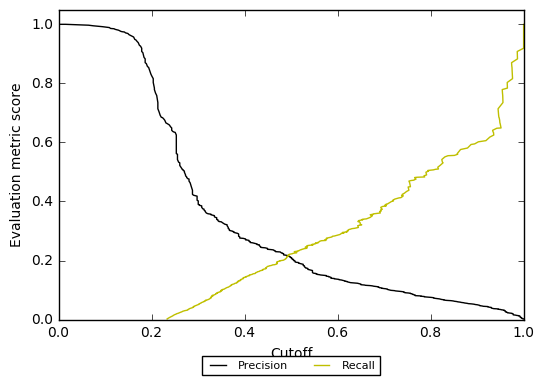

In [48]:
from IPython.display import Image
Image(filename=output_dir + ".cutoff.png")

## Precision-recall curve

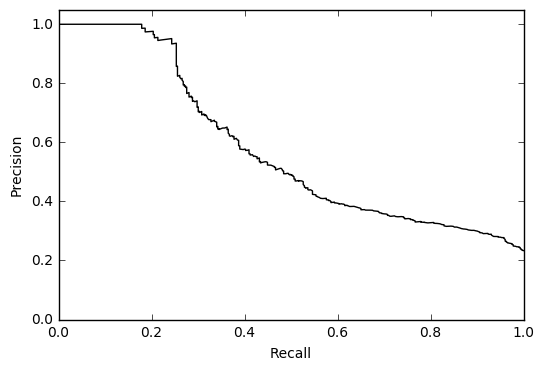

In [50]:
Image(filename=output_dir + ".pr.png")

## ROC curve

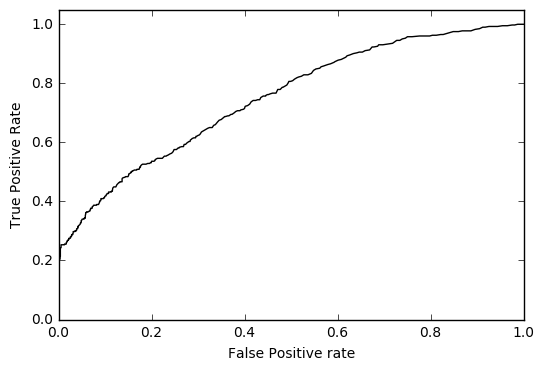

In [51]:
Image(filename=output_dir + ".roc.png")

In [52]:
# Predicting interaction network


genemania = ""
if mode != "exp":
	genemania = CS.Genemania("6239")
	genemania = genemania.getScoreCalc()

# Predict protein interaction
network =  utils.make_predictions(scoreCalc, mode, clf, train, genemania)
outFH = open("%s.%s.pred.txt" % (output_dir, mode), "w")
print >> outFH, "\n".join(network)
outFH.close()

(1506, 12)
to predict: 107180


In [53]:
# Predicting clusters
utils.predict_clusters("%s.%s.pred.txt" % (output_dir, mode), "%s.%s.clust.txt" % (output_dir, mode))

# Clustering evaluation

In [54]:
import GoldStandard as GS
# Evaluating predicted clusters
pred_clusters = GS.Clusters(False)
pred_clusters.read_file("%s.%s.clust.txt" % (output_dir, mode))
#utils.clustering_evaluation(train.complexes, pred_clusters, "Train", True)
utils.clustering_evaluation(eval.complexes, pred_clusters, "", True)

 mmr	0.198354891404
 overlapp	0.022099
 simcoe	0.038674
 mean_simcoe_overlap	0.033149
 sensetivity	0.058865248227
 ppv	0.417910447761
 accuracy	0.156845153716
 sep	0.166674519309


GoldStandard.py:416: RuntimeWarning: invalid value encountered in true_divide
  row_F = np.nan_to_num(row_F/np.sum(row_F, axis=1, keepdims=True))


('0.198354891404\t0.022099\t0.038674\t0.033149\t0.058865248227\t0.417910447761\t0.156845153716\t0.166674519309',
 ' mmr\t overlapp\t simcoe\t mean_simcoe_overlap\t sensetivity\t ppv\t accuracy\t sep')

In [55]:
# Uncomment these lines in order to update the Cytoscape.js extension
# ====================================================================
import notebook.nbextensions
notebook.nbextensions.install_nbextension('https://cdnjs.cloudflare.com/ajax/libs/cytoscape/2.7.14/cytoscape.js', user=True)
# ====================================================================

u'/Users/florian/Library/Jupyter/nbextensions/cytoscape.js'

In [56]:
%%javascript

// Use the Cytoscape.js extension and make cytoscape global
require(['nbextensions/cytoscape'], function (cytoscape) {
    window.cytoscape = cytoscape;
});

<IPython.core.display.Javascript object>

In [57]:
all_eData_head, all_eData_scores = utils.elutionDatas_to_treeview(elution_datas, foundprots)
clust_json, clust_edges, clust_nodes = utils.clusters_to_json(pred_clusters, network, all_eData_head, all_eData_scores)

# Clustering network

In [58]:
#clust_json, clust_edges, clust_nodes = clusters_to_json(pred_clusters, network)
clust_cy_js = utils.json_to_cy_js("clust_cy", clust_json)
clust_cy_div = widgets.HTML(value="""<div id='clust_cy' style="width: 100%; height: 500px; background: #f0f0f0;"></div>""")
clust_js_script = widgets.HTML(value = clust_cy_js)
display(clust_cy_div)
display(clust_js_script)

# Sending cluster data to running cytoscape instance

In [59]:
import requests

BASE, DATA, HEADERS = utils.prep_network_for_cy(clust_nodes, clust_edges)
res = requests.delete(BASE + 'session')
json.dumps(res.json())
req = requests.post(BASE + 'networks', data=DATA, headers=HEADERS)
